# Task 1: 10-Word Speech Recognition

**Student**: Aleksandr J. Smoliakov, VU MIF, Data Science, year 1  
**Date**: 22nd October 2024

In this report, we will build a speech recognition system that recognizes 10 words. The system will be based on the Mel-frequency cepstral coefficient (MFCC) features and a Convolutional Neural Network with 4 stacks of 2D convolution + max pooling, followed by 2 dense layers. Finally, we will evaluate the model on a test set and analyze the results.

## Dataset

The dataset used in this assignment is sampled from the **Google's Speech Commands Dataset** version **0.02**, which consists of 105 thousands of one-second long utterances of 30 short words. The dataset is available at https://huggingface.co/datasets/google/speech_commands.

In this assignment, we will use a subset of the dataset that contains 10 words:  
`zero`, `one`, `two`, `three`, `four`, `five`, `six`, `seven`, `eight`, and `nine`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS

from dataset_utils import SubsetSC, plot_confusion_matrix, calculate_confusion_matrix
from model import AudioClassifier

from audio_utils import transform_waveform, transform_waveform_20db, transform_waveform_40db

Downloading the full Speech Commands Dataset:

In [2]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

full_dataset = SPEECHCOMMANDS(root=data_dir, download=True)

assert len(full_dataset) == 105829

In [3]:
SELECTED_WORDS = [
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine",
]
CLASS_TO_IDX = dict(zip(SELECTED_WORDS, range(len(SELECTED_WORDS))))

Filtering the 10 words defined above and randomly selecting 200 samples for each word:

In [4]:
sample_metadata = [full_dataset.get_metadata(i) for i in range(len(full_dataset))]
df_sample_metadata = pd.DataFrame(
    sample_metadata,
    columns=["relpath", "sample_rate", "label", "speaker_id", "utterance_number"],
)
df_sample_metadata["walker_path"] = full_dataset._walker

# filter out the selected words
df_sample_metadata = df_sample_metadata[df_sample_metadata["label"].isin(SELECTED_WORDS)]
# sample 200 samples for each word
df_sample_metadata = df_sample_metadata.groupby("label").sample(200, random_state=42).reset_index(drop=True)

In [5]:
# set the order of the selected words
df_sample_metadata.label = pd.Categorical(
    df_sample_metadata.label,
    categories=SELECTED_WORDS,
)
df_sample_metadata.sort_values("label", inplace=True)
df_sample_metadata.reset_index(drop=True, inplace=True)

Let's split the samples into training (80%) and testing (20%) sets. Since the samples were randomly shuffled by `.sample()` above, we can simply assign every 5th sample to the test set without any bias.

In [6]:
df_sample_metadata["data_split"] = "train"
df_sample_metadata.loc[df_sample_metadata.index % 5 == 4, "data_split"] = "test"

## Exploratory Data Analysis

Let's plot the distribution of samples in the training and testing sets.

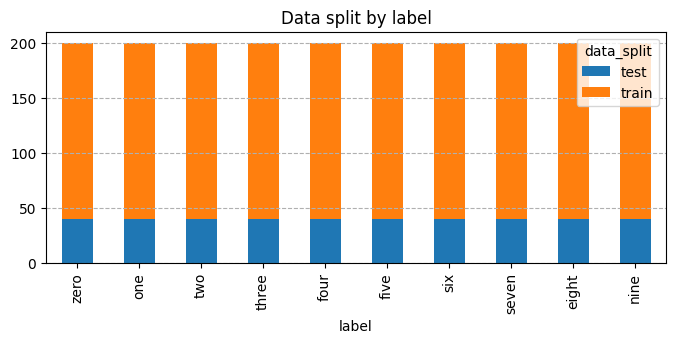

In [45]:
df_sample_metadata.groupby(
    ["label", "data_split"], observed=False
).data_split.count().unstack().plot.bar(
    stacked=True,
    figsize=(8, 3),
    title="Data split by label",
)

plt.grid(axis="y", linestyle="--")
plt.show()

Evidently, the dataset is perfectly balanced in terms of labels, with each word having exactly 160 samples in the training set and 40 samples in the testing set, as intended.

#### Speakers

The number of unique speakers in our dataset:

In [8]:
df_sample_metadata.speaker_id.nunique()

1160

Now, let's check the number of speakers of each word.

In [ ]:
df_sample_metadata.groupby(
    ["label"], observed=False
).speaker_id.nunique().to_frame().rename(
    columns={"speaker_id": "speakers"}
).T

label,zero,one,two,three,four,five,six,seven,eight,nine
speakers,187,191,189,193,184,184,188,185,184,191


The number of unique speakers per each word is between 82-91% of the total number of samples for each word. This means that the dataset is well balanced in terms of the number of speakers.

Distribution of the number of samples per speaker:

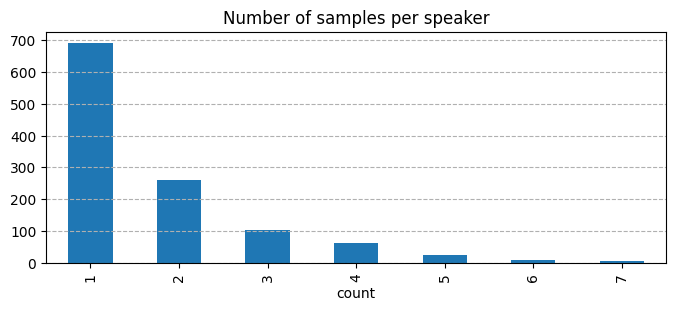

In [46]:
df_sample_metadata.speaker_id.value_counts().value_counts().sort_index().plot.bar(
    figsize=(8, 3),
    title="Number of samples per speaker",
)
plt.grid(axis="y", linestyle="--")
plt.show()

In our dataset, over half of the speakers have recorded only one sample, and over 90% of speakers have recorded 4 or fewer samples. There are a lot of unique speakers - this is likely to increase the in-class variability and make it more challenging for the model to fit to the training data.

However, this is likely to lead to a more robust model that generalizes well to unseen speakers.

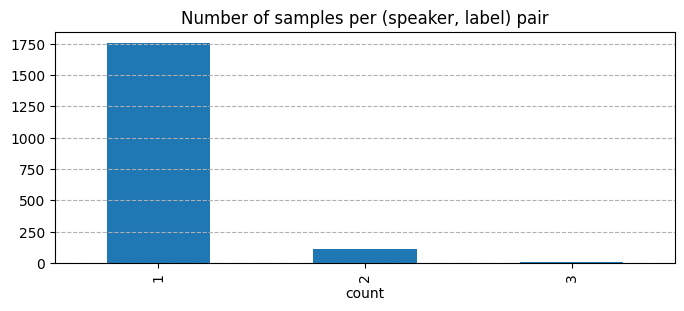

In [47]:
df_sample_metadata[["speaker_id", "label"]].value_counts().value_counts().sort_index().plot.bar(
    figsize=(8, 3),
    title="Number of samples per (speaker, label) pair",
)
plt.grid(axis="y", linestyle="--")
plt.show()

In our dataset, the vast majority of speakers only have a single utterance of a word. The maximum number of samples per (speaker, label) is 3, which is quite low.

#### Sample rate

The sample rate of all recordings is exactly 16 kHz:

In [12]:
df_sample_metadata.sample_rate.value_counts().to_frame()

,count
sample_rate,
16000,2000


## Feature extraction

We will use the Mel-frequency cepstral coefficients (MFCC) as features for our speech recognition model.
MFCCs are widely used in speech recognition systems because they mimic the human auditory system's response more closely than the raw audio signal. The frequency scale is scaled to the Mel scale, which is similar to the logarithmic scale.

Our parameters for the MFCC transformation:

* Sample size: 16000 Hz
* Maximum frequency: 4000 Hz
* Window size: 32 ms (512 samples)
* Hop length: 8 ms (128 samples)
* Number of MFCC coefficients: 20
* Number of Mel filters: 64

We will transform the raw audio samples into MFCC features the following way:

* Load the audio samples using `torchaudio`
* Pad/trim the audio to a fixed length of exactly 16000 samples at 16 kHz (1 second)
* Apply the MFCC transformation to the audio samples

### Create datasets

In [13]:
# dataset with no preprocessing
train_dataset_no_preproc = SubsetSC(
    root=data_dir,
    walker=df_sample_metadata[df_sample_metadata.data_split == "train"].walker_path.tolist(),
    class_to_idx=CLASS_TO_IDX,
    transform=None,
)

train_dataset = SubsetSC(
    root=data_dir,
    walker=df_sample_metadata[df_sample_metadata.data_split == "train"].walker_path.tolist(),
    class_to_idx=CLASS_TO_IDX,
    transform=transform_waveform,
)

test_dataset = SubsetSC(
    root=data_dir,
    walker=df_sample_metadata[df_sample_metadata.data_split == "test"].walker_path.tolist(),
    class_to_idx=CLASS_TO_IDX,
    transform=transform_waveform,
)

Let's plot the raw audio waveform and the MFCC features for a sample from the training set.

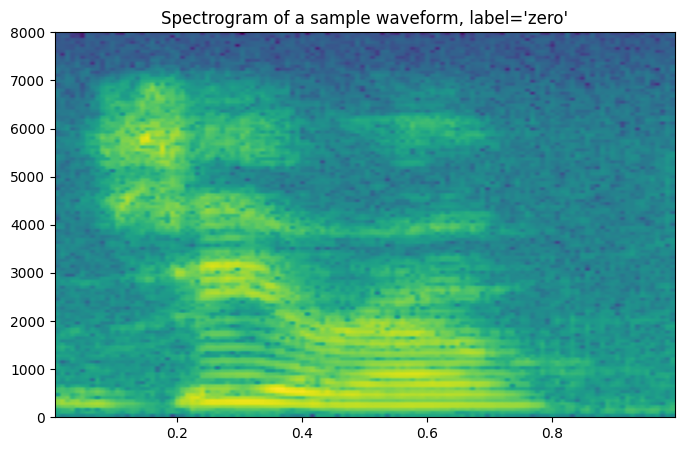

In [50]:
plt.figure(figsize=(8, 5))
plt.specgram(
    train_dataset_no_preproc[0][0][0].numpy(),
    Fs=16000,
)
plt.title(f"Spectrogram of a sample waveform, label='{SELECTED_WORDS[train_dataset_no_preproc[12][1]]}'")
plt.show()

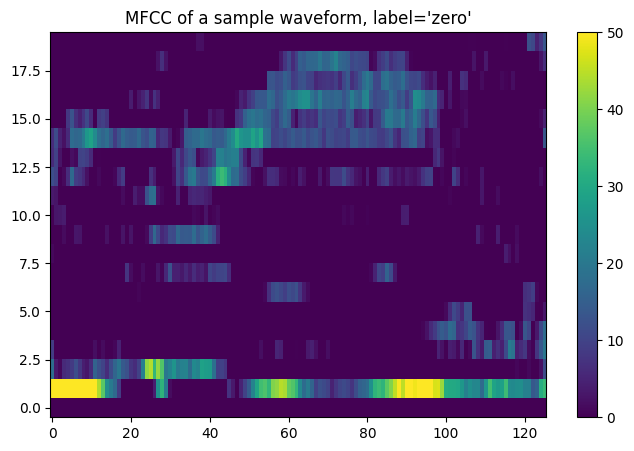

In [51]:
plt.figure(figsize=(8, 5))
plt.imshow(
    train_dataset[0][0][0],
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=50,
)
plt.title(f"MFCC of a sample waveform, label='{SELECTED_WORDS[train_dataset[0][1]]}'")
plt.colorbar()
plt.show()

MFCC features capture the essential information in the audio signal while significantly reducing the dimensionality of the input data.

## Model training

### Creating datasets and dataloaders

We will create PyTorch datasets and dataloaders for the training and testing sets. The full dataset of 5,000 samples has already been split into 4,000 samples for training and 1,000 samples for testing.

We will use a batch size of 32.

In [16]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

### Model architecture

We have considered using these model architectures:

* Convolutional Neural Network (CNN)
* Long Short-Term Memory (LSTM)

While Recurrent architectures like RNN, LSTM, and GRU can also be used for speech recognition, we have chosen to use a Convolutional Neural Network (CNN) for this task. CNNs are known to be very effective in image recognition tasks, and they can also be used for speech recognition.

In `model.py` we have defined a convolutional neural network with 4 stacks of 2D convolution + max pooling, followed by 2 dense layers. The model architecture is given below:

In [30]:
# train the model
model = AudioClassifier(num_classes=10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Let's visualize the model architecture:

In [31]:
print(model)

AudioClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=896, out_features=64, bias=

Let's train the model for 25 epochs and evaluate it on the test set.

In [32]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    running_loss = round(running_loss / len(train_loader.dataset), 3)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

    model.eval()
    n_correct = 0
    n_total = 0
    running_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            n_correct += (outputs.argmax(-1) == targets).sum().item()
            n_total += targets.size(0)

    running_loss = round(running_loss / len(test_loader.dataset), 3)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {running_loss}, Test Acc: {round(n_correct / n_total, 3)}")

Epoch 1/25, Loss: 2.426
Epoch 1/25, Test Loss: 2.295, Test Acc: 0.107
Epoch 2/25, Loss: 2.28
Epoch 2/25, Test Loss: 2.23, Test Acc: 0.212
Epoch 3/25, Loss: 2.147
Epoch 3/25, Test Loss: 2.042, Test Acc: 0.225
Epoch 4/25, Loss: 1.914
Epoch 4/25, Test Loss: 1.757, Test Acc: 0.36
Epoch 5/25, Loss: 1.682
Epoch 5/25, Test Loss: 1.552, Test Acc: 0.405
Epoch 6/25, Loss: 1.438
Epoch 6/25, Test Loss: 1.259, Test Acc: 0.59
Epoch 7/25, Loss: 1.192
Epoch 7/25, Test Loss: 1.288, Test Acc: 0.583
Epoch 8/25, Loss: 1.065
Epoch 8/25, Test Loss: 0.956, Test Acc: 0.69
Epoch 9/25, Loss: 0.884
Epoch 9/25, Test Loss: 0.866, Test Acc: 0.72
Epoch 10/25, Loss: 0.76
Epoch 10/25, Test Loss: 0.801, Test Acc: 0.735
Epoch 11/25, Loss: 0.69
Epoch 11/25, Test Loss: 0.784, Test Acc: 0.728
Epoch 12/25, Loss: 0.613
Epoch 12/25, Test Loss: 0.659, Test Acc: 0.782
Epoch 13/25, Loss: 0.562
Epoch 13/25, Test Loss: 0.692, Test Acc: 0.762
Epoch 14/25, Loss: 0.514
Epoch 14/25, Test Loss: 0.649, Test Acc: 0.795
Epoch 15/25, Loss:

The model has been successfully trained on the training set. Its loss has decreased over time until the test loss has started to converge. The model has achieved a test accuracy of 82.8% after 25 epochs.

Let's evaluate the model on the test set and plot the confusion matrix.

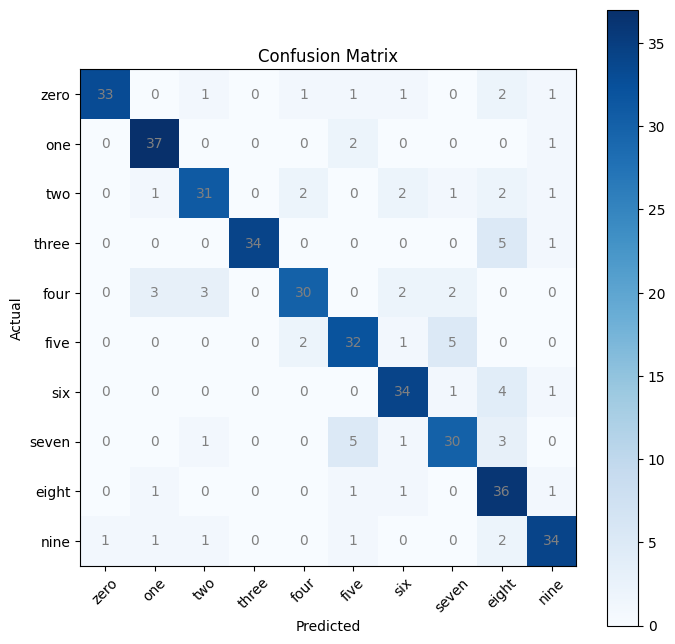

Accuracy: 0.8275


In [33]:
with torch.no_grad():
    activations = np.concatenate([model(k) for k, v in test_loader])
    predictions = np.argmax(activations, axis=1)

confusion_matrix = calculate_confusion_matrix(test_dataset, predictions)
plot_confusion_matrix(confusion_matrix, SELECTED_WORDS)

print("Accuracy:", np.diag(confusion_matrix).sum() / confusion_matrix.sum())

### Adding noise to the training data

Let's test our model on noisy data. We will add 40 dB, then 20 dB of white noise to the test data and evaluate the model's performance.

### 40 dB white noise

In [34]:
test_dataset_40db = SubsetSC(
    root=data_dir,
    walker=df_sample_metadata[df_sample_metadata.data_split == "test"].walker_path.tolist(),
    class_to_idx=CLASS_TO_IDX,
    transform=transform_waveform_40db,
)

test_loader_40db = DataLoader(
    test_dataset_40db,
    batch_size=32,
    shuffle=False,
)

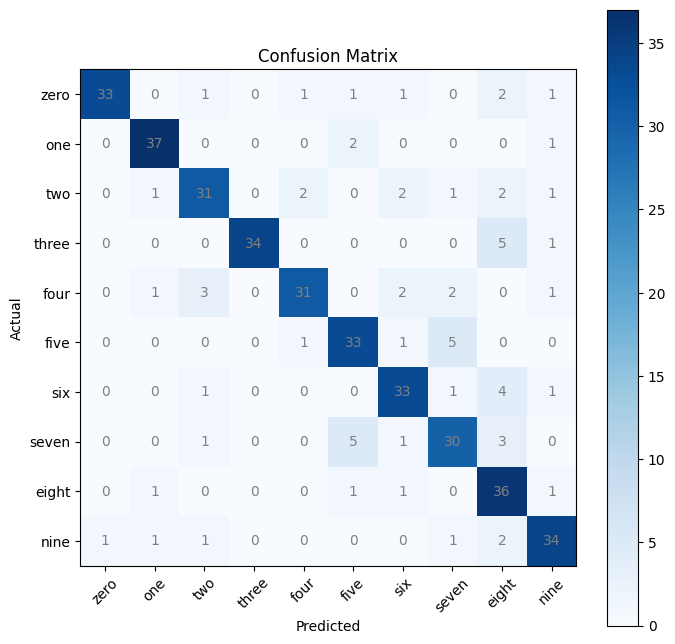

Accuracy with 40db SNR: 0.83


In [35]:
with torch.no_grad():
    activations = np.concatenate([model(k) for k, v in test_loader_40db])
    predictions = np.argmax(activations, axis=1)

confusion_matrix = calculate_confusion_matrix(test_dataset_40db, predictions)
plot_confusion_matrix(confusion_matrix, SELECTED_WORDS)

print("Accuracy with 40db SNR:", np.diag(confusion_matrix).sum() / confusion_matrix.sum())

The accuracy of the model on the test set with 40 dB white noise is 83.0%, which negligibly (by 0.2%) higher than the accuracy on the clean test set. This indicates that the model is robust to 40 dB white noise.

### 20 dB white noise

In [43]:
test_dataset_20db = SubsetSC(
    root=data_dir,
    walker=df_sample_metadata[df_sample_metadata.data_split == "test"].walker_path.tolist(),
    class_to_idx=CLASS_TO_IDX,
    transform=transform_waveform_20db,
)

test_loader_20db = DataLoader(
    test_dataset_20db,
    batch_size=32,
    shuffle=False,
)

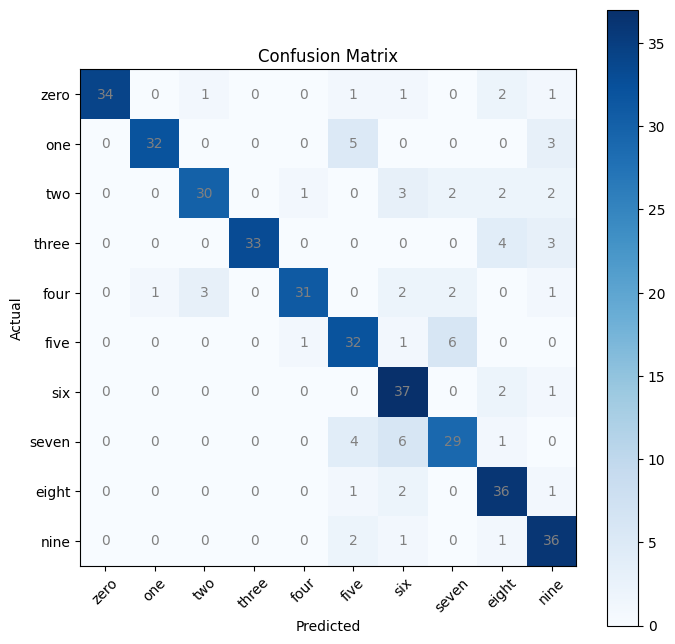

Accuracy with 20db SNR: 0.825


In [44]:
with torch.no_grad():
    activations = np.concatenate([model(k) for k, v in test_loader_20db])
    predictions = np.argmax(activations, axis=1)

confusion_matrix = calculate_confusion_matrix(test_dataset_20db, predictions)
plot_confusion_matrix(confusion_matrix, SELECTED_WORDS)

print("Accuracy with 20db SNR:", np.diag(confusion_matrix).sum() / confusion_matrix.sum())

The accuracy of the model on the test set with 20 dB white noise is 82.5%, which is by 0.3% lower than the accuracy on the clean test set. This indicates that the model is still quite robust to 20 dB white noise.